In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

2024-08-04 06:14:31.577005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 06:14:31.577151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 06:14:31.728542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.15.0
TensorFlow Decision Forests v1.8.1


In [3]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (617, 58)


In [4]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


<Axes: ylabel='count'>

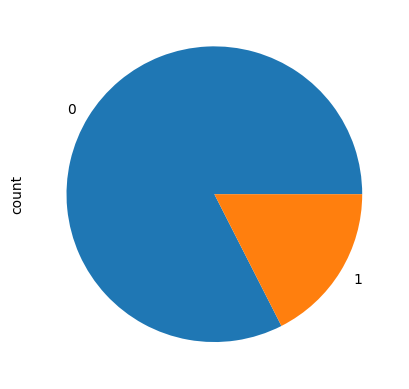

In [5]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

In [6]:
# Store all the numerical column names into a list
NUM_FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]

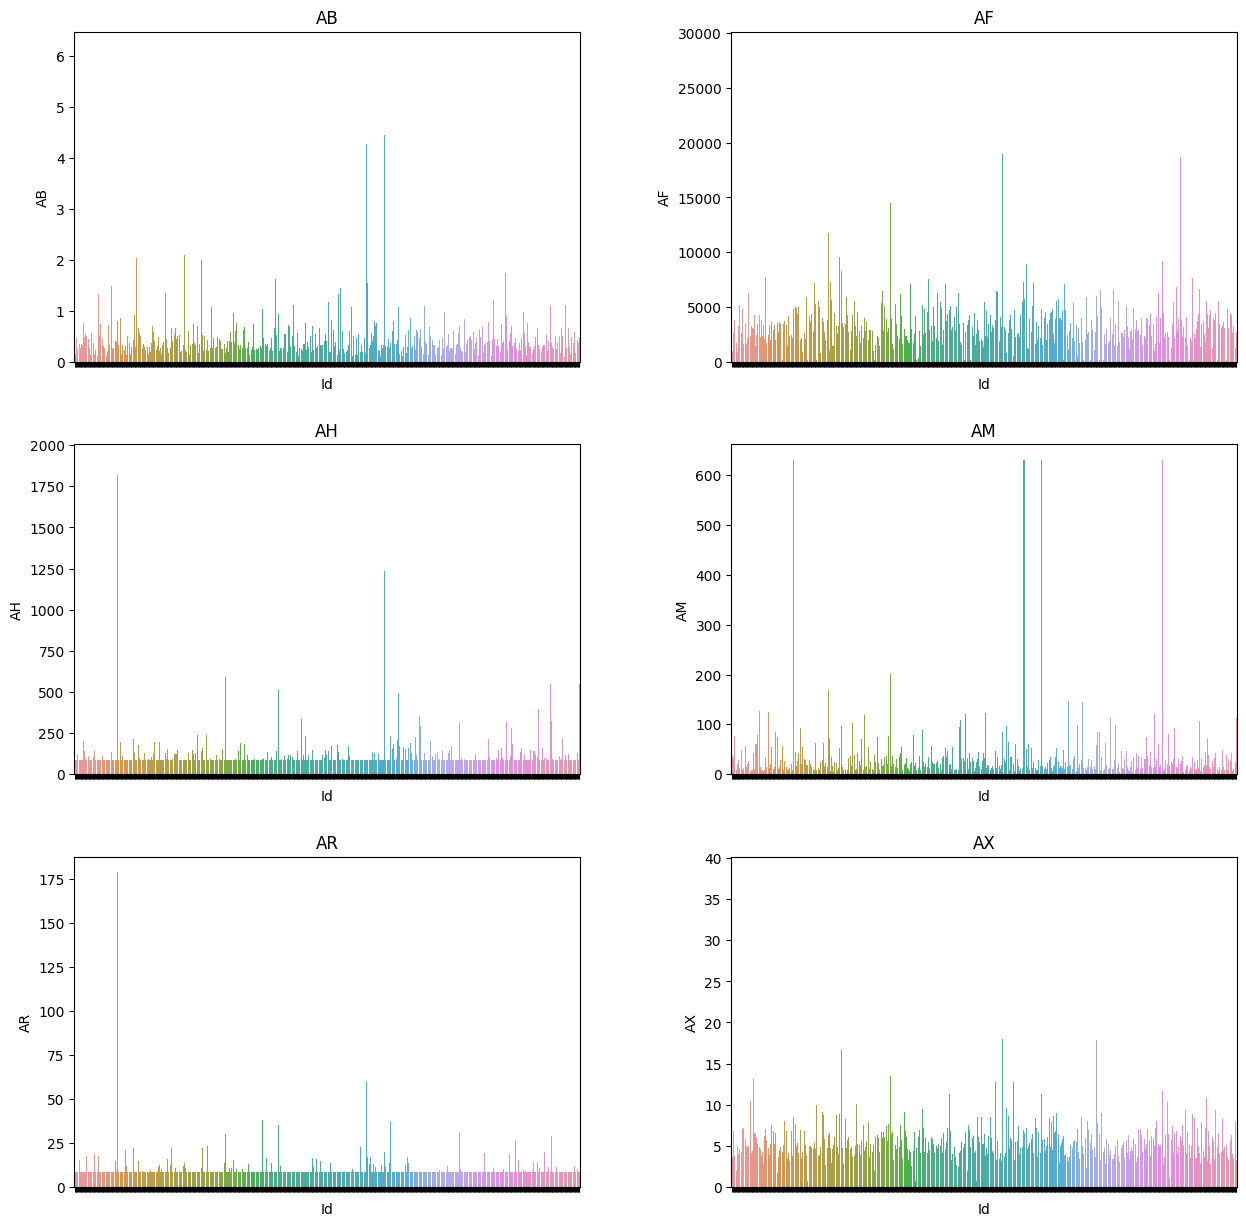

In [7]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=dataset_df['Id'], y=dataset_df[column_name])
    bp.set(xticklabels=[])
    #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title(column_name)
plt.show()

In [8]:
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id"]]

In [9]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5)

In [10]:
# Create list of ids for the creation of oof dataframe.
ID_LIST = dataset_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

In [11]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [12]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(dataset_df['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



In [13]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


In [14]:
# Loop through each fold
for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = dataset_df.iloc[train_index]
        valid_df = dataset_df.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[FEATURE_COLUMNS]
        valid_df = valid_df[FEATURE_COLUMNS]
        
        # There's one more step required before we can train the model. 
        # We need to convert the datatset from Pandas format (pd.DataFrame)
        # into TensorFlow Datasets format (tf.data.Dataset).
        # TensorFlow Datasets is a high performance data loading library 
        # which is helpful when training neural networks with accelerators like GPUs and TPUs.
        # Note: Some column names contains white spaces at the end of their name, 
        # which is non-comaptible with SavedModels save format. 
        # By default, `pd_dataframe_to_tf_dataset` function will convert 
        # this column names into a compatible format. 
        # So you can safely ignore the warnings related to this.
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        rf = tfdf.keras.RandomForestModel()
        rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
        
        # Train the model
        # We will train the model using a one-liner.
        # Note: you may see a warning about Autograph. 
        # You can safely ignore this, it will be fixed in the next release.
        # Previously calculated class weights is used to handle imbalance.
        rf.fit(x=train_ds, class_weight=class_weight)
        
        # Store the model
        models[f"fold_{i+1}"] = rf
        
        
        # Predict OOF value for validation data
        predict = rf.predict(x=valid_ds)
        
        # Store the predictions in oof dataframe
        oof.loc[valid_ids, 0] = predict.flatten() 
        
        # Evaluate and store the metrics in respective dicts
        evaluation = rf.evaluate(x=valid_ds,return_dict=True)
        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
        cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

##### Fold 1
Use /tmp/tmpl978npdr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:08.259247. Found 493 examples.
Training model...
Model trained in 0:00:00.289780
Compiling model...


[INFO 24-08-04 06:15:25.6340 UTC kernel.cc:1233] Loading model from path /tmp/tmpl978npdr/model/ with prefix 9454c86dc1da4f56
[INFO 24-08-04 06:15:25.6908 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14268 node(s), and 56 input feature(s).
[INFO 24-08-04 06:15:25.6908 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-04 06:15:25.6909 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.9516 - binary_crossentropy: 0.2182
##### Fold 2
Use /tmp/tmp1eq61wc6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.025935. Found 493 examples.
Training model...
Model trained in 0:00:00.259858
Compiling model...


[INFO 24-08-04 06:15:43.0696 UTC kernel.cc:1233] Loading model from path /tmp/tmp1eq61wc6/model/ with prefix 8a8ec08a327b4c72
[INFO 24-08-04 06:15:43.1243 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13582 node(s), and 56 input feature(s).
[INFO 24-08-04 06:15:43.1244 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-04 06:15:43.1244 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 550ms/step - loss: 0.0000e+00 - accuracy: 0.8790 - binary_crossentropy: 0.2608
##### Fold 3
Use /tmp/tmp0d47j1e6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.058355. Found 494 examples.
Training model...
Model trained in 0:00:00.256366
Compiling model...


[INFO 24-08-04 06:15:45.9579 UTC kernel.cc:1233] Loading model from path /tmp/tmp0d47j1e6/model/ with prefix c0f7b896a0fe4594
[INFO 24-08-04 06:15:46.0122 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13376 node(s), and 56 input feature(s).
[INFO 24-08-04 06:15:46.0123 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 565ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2741
##### Fold 4
Use /tmp/tmpu78joumj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.044040. Found 494 examples.
Training model...
Model trained in 0:00:00.251787
Compiling model...


[INFO 24-08-04 06:15:48.8509 UTC kernel.cc:1233] Loading model from path /tmp/tmpu78joumj/model/ with prefix c82a88bc3239466e
[INFO 24-08-04 06:15:48.9039 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13434 node(s), and 56 input feature(s).
[INFO 24-08-04 06:15:48.9040 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 559ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2717
##### Fold 5
Use /tmp/tmpjnz0ib4d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.036921. Found 494 examples.
Training model...
Model trained in 0:00:00.256008
Compiling model...


[INFO 24-08-04 06:15:51.7187 UTC kernel.cc:1233] Loading model from path /tmp/tmpjnz0ib4d/model/ with prefix 2123ade944024cac
[INFO 24-08-04 06:15:51.7749 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13980 node(s), and 56 input feature(s).
[INFO 24-08-04 06:15:51.7749 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 552ms/step - loss: 0.0000e+00 - accuracy: 0.9512 - binary_crossentropy: 0.2172


In [15]:
tfdf.model_plotter.plot_model_in_colab(models['fold_1'], tree_idx=0, max_depth=3)

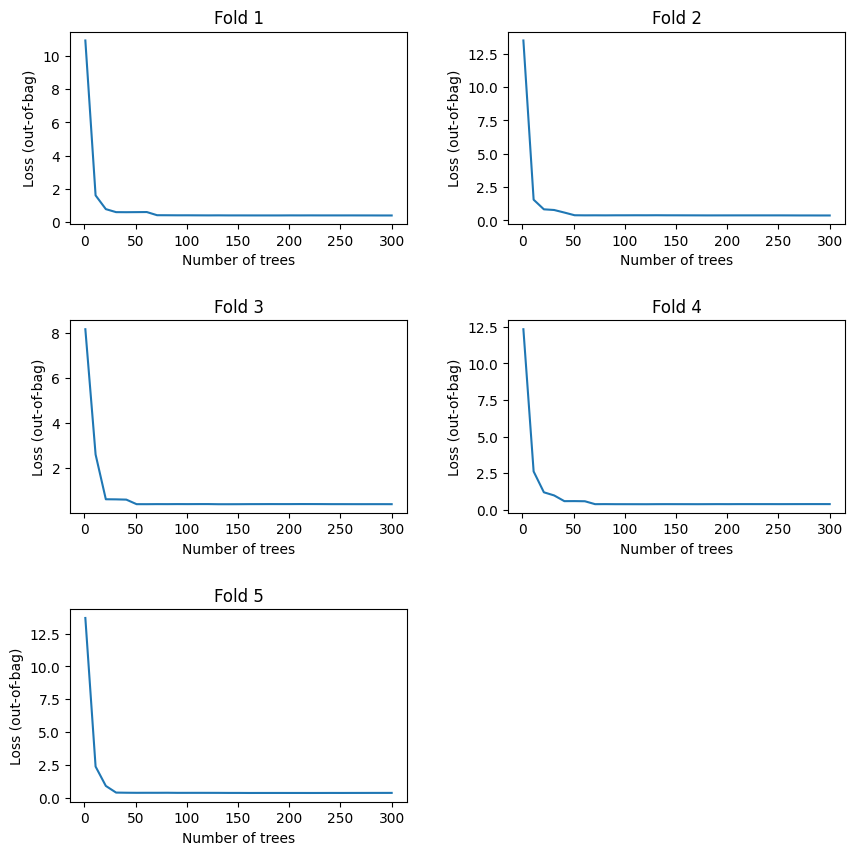

In [16]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

In [17]:
for _model in models:
    inspector = models[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=493, accuracy=0.83384120423487, loss=0.4011864148867133, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=493, accuracy=0.86791143186256, loss=0.374230902610848, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=494, accuracy=0.8625237360976467, loss=0.39912028399338717, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=494, accuracy=0.8742180068903357, loss=0.38689070260817593, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=494, accuracy=0.8477430594687857, loss=0.39049966583287166, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


In [18]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9516 loss: 0.2182
fold_2: acc: 0.8790 loss: 0.2608
fold_3: acc: 0.9024 loss: 0.2741
fold_4: acc: 0.9024 loss: 0.2717
fold_5: acc: 0.9512 loss: 0.2172

Average accuracy: 0.9173  Average loss: 0.2484


In [19]:
inspector = models['fold_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH


In [20]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("DU" (1; #32), 47.0),
 ("DI" (1; #29), 25.0),
 ("DA" (1; #25), 21.0),
 ("AB" (1; #0), 19.0),
 ("FL" (1; #47), 19.0),
 ("GL" (1; #55), 18.0),
 ("BQ" (1; #12), 16.0),
 ("CR" (1; #21), 16.0),
 ("FD_" (1; #44), 16.0),
 ("CD_" (1; #17), 14.0),
 ("AF" (1; #1), 13.0),
 ("CC" (1; #16), 8.0),
 ("DF" (1; #27), 7.0),
 ("AR" (1; #4), 6.0),
 ("DH" (1; #28), 6.0),
 ("EB" (1; #35), 6.0),
 ("FI" (1; #46), 6.0),
 ("BC" (1; #8), 5.0),
 ("EH" (1; #38), 5.0),
 ("FR" (1; #48), 5.0),
 ("DE" (1; #26), 4.0),
 ("DL" (1; #30), 4.0),
 ("EE" (1; #36), 4.0),
 ("FE" (1; #45), 4.0),
 ("EU" (1; #42), 3.0),
 ("BN" (1; #10), 2.0),
 ("EL" (1; #40), 1.0)]

In [21]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.tolist()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
                        if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd)
predictions = models['fold_1'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)

1/1 [==============================] - 0s 166ms/step
[[0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643]]


In [22]:
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)